In [1]:
import os
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
A = loadmat("./Data_P3/A.mat")["A"].astype(np.float64)
b = loadmat("./Data_P3/b.mat")["b"].astype(np.float64)
X0 = loadmat("./Data_P3/x_0.mat")["x_0"].astype(np.float64)
X1 = loadmat("./Data_P3/x_1.mat")["x_1"].astype(np.float64)

In [3]:
A.shape

(30, 100)

In [4]:
#内置的一维精确搜索算法为牛顿法
class Func():
    def __init__(self, A, b):
        self.delta = 1e-11
        self.epsilon = 1e-11
        self.A = A
        self.n = A.shape[1]
        self.m = A.shape[0]
        self.b = b
        
    def value(self, X):
        return np.sum(X*np.log(X))
    
    def grad(self, X):
        return np.log(X)+1
        
    def hessian(self, X):
        return np.eye(self.n)/X
    
    def diff_t(self, X, D, t):
        return np.dot(self.grad(X+t*D).T, D)
    
    def diff_2_t(self, X, D, t):
        return np.dot(D.T, np.dot(self.hessian(X+t*D), D))
    
    def r_norm(self, X, V):
        r_dual = self.grad(X)+np.dot(self.A.T, V)
        r_pri = np.dot(self.A, X)-self.b
        r = np.concatenate([r_dual, r_pri], axis=0)
        return np.linalg.norm(r)
    
    def Newton_1D_Method(self, X0, D, delta):#一维精确搜索——牛顿法
        t_tmp=0
        while(abs(self.diff_t(X0,D,t_tmp))>delta or delta_t>1e-3):
            t_tmp = new_t_tmp
            #if(np.sum((X0+t_tmp+D<=0))>0):
            #    break
            new_t_tmp=t_tmp-self.diff_t(X0,D,t_tmp)/self.diff_2_t(X0,D,t_tmp)
            delta_t = np.abs(new_t_tmp - t_tmp)
            t_tmp = new_t_tmp
        return X0+t_tmp*D
    
    def Backtracking1(self, X0, D, delta, alpha = 0.5, beta = 0.9):
        t = 1
        """↓↓↓↓↓↓↓↓控制步长，防止走出函数定义域↓↓↓↓↓↓↓↓"""
        idxs = np.where(X0+t*D<0)
        scale = np.abs(X0[idxs])/np.abs((t*D)[idxs])
        if(scale.shape[0]>0):
            t = t*np.min(scale)*0.9
        """↑↑↑↑↑↑↑↑控制步长，防止走出函数定义域↑↑↑↑↑↑↑↑"""
        while(self.value(X0+t*D) > self.value(X0) + alpha*t*np.dot(self.grad(X0).T,D)):
            t = beta*t

        return X0+t*D, t
    
    def Backtracking2(self, X0, D, w0, w, delta, alpha = 0.5, beta = 0.9):
        t = 1
        """↓↓↓↓↓↓↓↓控制步长，防止走出函数定义域↓↓↓↓↓↓↓↓"""
        idxs = np.where(X0+t*D<0)
        scale = np.abs(X0[idxs])/np.abs((t*D)[idxs])
        if(scale.shape[0]>0):
            t = t*np.min(scale)*0.9
        """↑↑↑↑↑↑↑↑控制步长，防止走出函数定义域↑↑↑↑↑↑↑↑"""
        while(self.r_norm(X0+t*D, (1-t)*w0+t*w) > (1-alpha*t)*self.r_norm(X0, w0)):
            t = beta*t
            
        return X0+t*D, (1-t)*w0+t*w, t
    
    def NewtonMethod(self, X0, epsilon):
        if(np.sum(np.abs(np.dot(self.A, X0) - self.b))!=0):
            tmp_x = X0
            values = [self.value(tmp_x)]
            t_ks = []
            v = -np.linalg.inv(self.A@(self.A.T))@self.A@self.grad(tmp_x)
            r = self.r_norm(tmp_x, v)  
            print("error: ", (r))
            while(r > epsilon):
                hessian = self.hessian(tmp_x)
                hessian_inv = np.linalg.inv(hessian)
                m = np.dot(hessian_inv, self.A.T)
                n = np.dot(hessian_inv, self.grad(tmp_x))
                S = -np.dot(self.A, m)
                w = np.linalg.inv(self.A@m)@(self.A@(tmp_x-n)-self.b)
                d = -np.dot(m, w)-n
                tmp_x, v, t_k = self.Backtracking2(tmp_x, d, v, w, self.delta)
                r = self.r_norm(tmp_x, v)
                values.append(self.value(tmp_x))
                t_ks.append(t_k)
                print("error: ", (r))
        else:
            tmp_x = X0
            values = [self.value(tmp_x)]
            t_ks = []
            hessian = self.hessian(tmp_x)
            hessian_inv = np.linalg.inv(hessian)
            a = np.dot(hessian_inv, self.A.T)
            b = np.dot(hessian_inv, self.grad(tmp_x))
            S = -np.dot(self.A, a)
            w = np.dot(np.dot(np.linalg.inv(S), self.A), b)
            d = -np.dot(hessian_inv, (np.dot(self.A.T, w))) - b
            lambda_square = np.dot(d.T, np.dot(hessian, d))
            #print(np.prod(np.dot(self.A, tmp_x) - self.b))
            print("error: ", lambda_square/2)
            while(lambda_square/2 > epsilon):
                tmp_x, t_k = self.Backtracking1(tmp_x, d, self.delta)
                #print(tmp_x)
                hessian = self.hessian(tmp_x)
                hessian_inv = np.linalg.inv(hessian)
                a = np.dot(hessian_inv, self.A.T)
                b = np.dot(hessian_inv, self.grad(tmp_x))
                S = -np.dot(self.A, a)
                w = np.dot(np.dot(np.linalg.inv(S), self.A), b)
                d = -np.dot(hessian_inv, (np.dot(self.A.T, w))) - b
                lambda_square = np.dot(d.T, np.dot(hessian, d))
                values.append(self.value(tmp_x))
                t_ks.append(t_k)
                print("error: ", lambda_square/2)
            
        return tmp_x, self.value(tmp_x), np.array(values), np.array(t_ks).reshape(-1)

In [5]:
func1 = Func(A,b)
opt_point1, opt_value1, values1, tks1 = func1.NewtonMethod(X0, epsilon=1e-10)

error:  [[6.95369236]]
error:  [[0.97826126]]
error:  [[0.25108259]]
error:  [[0.02955343]]
error:  [[0.00069391]]
error:  [[9.10589875e-07]]
error:  [[2.41862799e-12]]


/tmp/ipykernel_351/1125663275.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(values1-opt_value1), "-o", label="optimal value = %f"%(opt_value1))


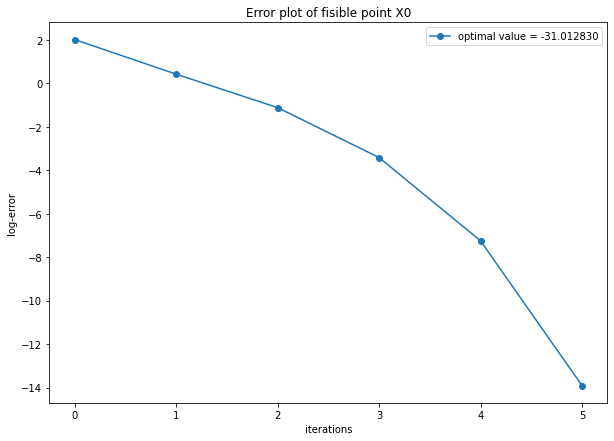

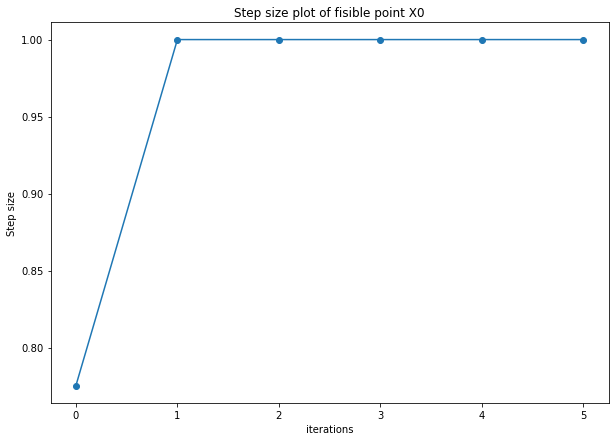

In [6]:
plt.figure(figsize=(10,7))
plt.plot(np.log(values1-opt_value1), "-o", label="optimal value = %f"%(opt_value1))
plt.xlabel("iterations")
plt.ylabel("log-error")
plt.title("Error plot of fisible point X0")
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(tks1, "-o")
plt.xlabel("iterations")
plt.ylabel("Step size")
plt.title("Step size plot of fisible point X0")
plt.show()

In [7]:
opt_point2, opt_value2, values2, tks2 = func1.NewtonMethod(X1, epsilon=1e-10)

error:  11.98554815274901
error:  4.197150363829874
error:  0.24818990852149128
error:  0.010717745654179829
error:  4.268598993891472e-05
error:  7.35219091555497e-10
error:  9.407645798943653e-15


/tmp/ipykernel_351/366489384.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(values2-opt_value2), "-o", label="optimal value = %f"%(opt_value2))
/tmp/ipykernel_351/366489384.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(values2-opt_value2), "-o", label="optimal value = %f"%(opt_value2))


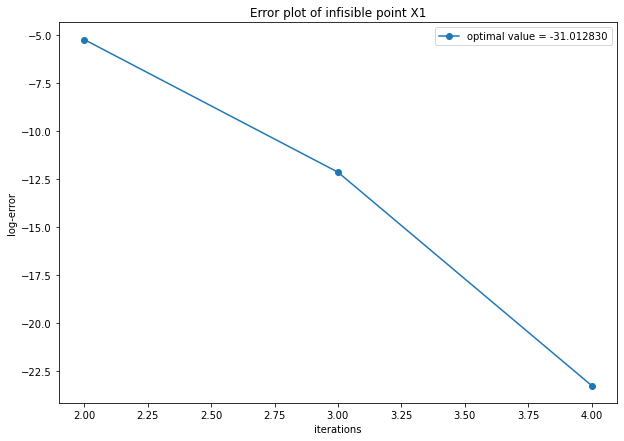

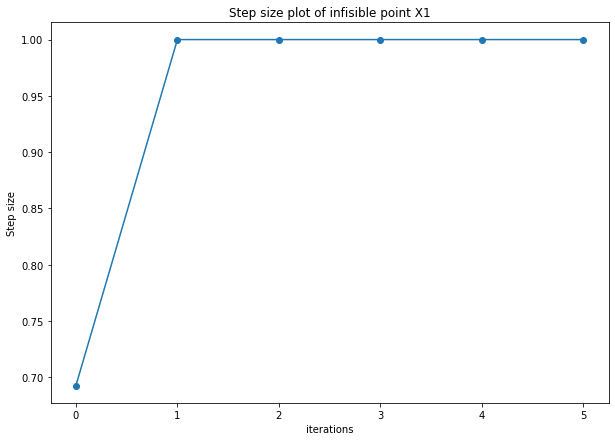

In [8]:
plt.figure(figsize=(10,7))
plt.plot(np.log(values2-opt_value2), "-o", label="optimal value = %f"%(opt_value2))
plt.xlabel("iterations")
plt.ylabel("log-error")
plt.title("Error plot of infisible point X1")
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(tks2, "-o")
plt.xlabel("iterations")
plt.ylabel("Step size")
plt.title("Step size plot of infisible point X1")
plt.show()